In [ ]:
# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
# import tensorflow as tf 

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
# cd C:\Users\ASUS\Desktop\dataset-460-40

[Errno 2] No such file or directory: 'C:UsersASUSDesktopdataset-460-40'
/content


In [ ]:
import os
import json
from glob import glob
import numpy as np
from numpy import array
from numpy import argmax
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Activation, Dense

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
tf.random.set_seed(123)

### Data Preprocessing

In [ ]:
def get_compiled_data(path):
    f_path = path
    f_list = sorted(glob(os.path.join(f_path, "*.json")))

    f_compile =[]

    for j in f_list: 
        file = open(j, "r")
        content = file.read()
        data = json.loads(content)
        f_compile.append(data)
    return f_compile

In [ ]:
# X = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x")
# y = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y")
X = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x/")
y = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y/")

In [ ]:
#Find min and max values of coordinates
coord_values = []
for i in range(len(X)):
  data = X[i] 
  for j in range(len(data)):
    data1 = data[j]
    for k in range(len(data1)):
      coord_values.append(data1[k])
print(min(coord_values))
print(max(coord_values))

0
499


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=1)

In [ ]:
print(len(X_train), len(y_train)) 

414 414


### Data Augmentation for X_train and y_train

In [ ]:
# ##Data Augmentation (reverse seq)
# for i in range(len(X_train)):
#   compiled_x_reverse = X_train[i][::-1]
#   X_train.append(compiled_x_reverse)

# for i in range(len(y_train)):
#   compiled_y_reverse = y_train[i][::-1]
#   y_train.append(compiled_y_reverse)

In [ ]:
# print(len(X_train))
# len(y_train)

4140


4140

In [ ]:
# #Data Augmentation (translation by 5 units up and right)
# X_train_trans_aug_1 = [[[v+1 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_2 = [[[v+3 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_3 = [[[v+5 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_4 = [[[v+7 for v in inner1] for inner1 in inner] for inner in X_train]

In [ ]:
# import copy
# y_train_trans_aug = copy.deepcopy(y_train)

In [ ]:
# X_train.extend(X_train_trans_aug_1)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_2)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_3)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_4)
# y_train.extend(y_train_trans_aug)

In [ ]:
# print(len(X_train), len(y_train)) 

4140 4140


Remove sequences with values above 499

In [ ]:
compiled_x = []
compiled_y = []

for i, seq in enumerate(X_train):
  value_check=[]
  for _, coord in enumerate(seq):
    coord_01 = coord[0]
    coord_02 = coord[1]
    value_check.append(coord_01)
    value_check.append(coord_02)
  if max(value_check) < 500:
    compiled_x.append(seq)
    compiled_y.append(y_train[i])
    

In [ ]:
print(len(compiled_x), len(compiled_y), len(X_valid), len(y_valid))

3786 3786 46 46


In [ ]:
#For variable naming standardisation, "rename" X_valid to compiled_x_valid
compiled_x_valid = X_valid
compiled_y_valid = y_valid

### For encoder input (training)

In [ ]:
encoder_input = []
for i in range(len(compiled_x)):
  data = compiled_x[i]   
  while len(data) < 267:                        #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                      #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input.append(data)

In [ ]:
encoder_input = np.array(encoder_input)
encoder_input.shape

(3786, 267, 2)

One-hot encode encoder input (training)

In [ ]:
# Concatenate all coordinates side by side so that [(12,15),(23, 30),(32, 41),...] becomes [12,15,23,30,32,41,...]
X1 = list()
for i in range(encoder_input.shape[0]):
  row=list()
  for j in range(267):                          #267 because there are 267 time-step in each sequence
    row.append(encoder_input[i][j][0])
    row.append(encoder_input[i][j][1])
  X1.append(row)

In [ ]:
X1 = np.array(X1)
X1.shape

(3786, 534)

In [ ]:
X1 = to_categorical([X1], num_classes=501)      #501 cuz 0-499 for input values, 500 for padding
X1.shape

(1, 3786, 534, 501)

In [ ]:
X1 = X1.reshape(3786, 534, 501)
X1.shape

(3786, 534, 501)

### For encoder input (validation)

In [ ]:
encoder_input_valid = []
for i in range(len(compiled_x_valid)):
  data = compiled_x_valid[i]   
  while len(data) < 267:                        #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                      #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_valid.append(data)

In [ ]:
encoder_input_valid = np.array(encoder_input_valid)
encoder_input_valid.shape

(46, 267, 2)

In [ ]:
X1_valid = list()
for i in range(encoder_input_valid.shape[0]):
  row=list()
  for j in range(267):                           #267 cuz there are 267 time-step in each sequence
    row.append(encoder_input_valid[i][j][0])
    row.append(encoder_input_valid[i][j][1])
  X1_valid.append(row)

In [ ]:
X1_valid = np.array(X1_valid)
X1_valid.shape

(46, 534)

In [ ]:
X1_valid = to_categorical([X1_valid], num_classes=501)
X1_valid.shape

(1, 46, 534, 501)

In [ ]:
X1_valid = X1_valid.reshape(46, 534, 501)
X1_valid.shape

(46, 534, 501)

### For decoder_target (training)

In [ ]:
Y = []
for i in range(len(compiled_y)):
  data = compiled_y[i]                                   
  while len(data) < 267:                         #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y.append(data)

In [ ]:
Y = np.array(Y)
Y.shape

(3786, 267)

In [ ]:
Y = Y.reshape(3786, 267, 1)                  
Y.shape

(3786, 267, 1)

In [ ]:
Y = to_categorical([Y], num_classes=4)
Y.shape

(1, 3786, 267, 4)

In [ ]:
Y = Y.reshape(3786, 267, 4)
Y.shape

(3786, 267, 4)

### For decoder_target (validation)

In [ ]:
Y_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i]                                   
  while len(data) < 267:                        #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y_valid.append(data)

In [ ]:
Y_valid = np.array(Y_valid)
Y_valid.shape

(46, 267)

In [ ]:
Y_valid = Y_valid.reshape(46, 267, 1)    
Y_valid.shape

(46, 267, 1)

In [ ]:
Y_valid = to_categorical([Y_valid], num_classes=4)
Y_valid.shape

(1, 46, 267, 4)

In [ ]:
Y_valid = Y_valid.reshape(46, 267, 4)
Y_valid.shape

(46, 267, 4)

### For decoder input (shifted version of decoder target) - (training)

In [ ]:
X2 = []
for i in range(len(compiled_y)):
  data = compiled_y[i] 
  while len(data) < 267:                         #Make all samples to be of the same sequence length by padding it with two
    data.append(2)
  data = [3] + data[:-1]                         #3 for indicating start of decoder input sequence (requirement for force teaching)
  X2.append(data)

In [ ]:
X2 = np.array(X2)
X2.shape

(3786, 267)

In [ ]:
X2 = X2.reshape(3786, 267, 1)
X2.shape

(3786, 267, 1)

In [ ]:
X2 = to_categorical([X2], num_classes=4)
X2.shape

(1, 3786, 267, 4)

In [ ]:
X2 = X2.reshape(3786, 267, 4)
X2.shape

(3786, 267, 4)

### For decoder input (shifted version of decoder target) - (validation)

In [ ]:
X2_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i] 
  while len(data) < 267:                        #Make all samples to be of the same sequence length by padding it with two
    data.append(2)
  data = [3] + data[:-1]                        #3 for indicating start of decoder input sequence (requirement for force teaching)
  X2_valid.append(data)

In [ ]:
X2_valid = np.array(X2_valid)
X2_valid.shape

(46, 267)

In [ ]:
X2_valid = X2_valid.reshape(46, 267, 1)
X2_valid.shape

(46, 267, 1)

In [ ]:
X2_valid = to_categorical([X2_valid], num_classes=4)
X2_valid.shape

(1, 46, 267, 4)

In [ ]:
X2_valid = X2_valid.reshape(46, 267, 4)
X2_valid.shape

(46, 267, 4)

### Creation of test samples

In [ ]:
#compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x_test")
compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x_test/")

In [ ]:
encoder_input_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i]   
  while len(data) < 267:                         #The sequence length of the longest input sample was earlier found to be 267 (not shown in this colab)
    data.append([500,500])                       #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_test.append(data)

In [ ]:
encoder_input_test = np.array(encoder_input_test)
encoder_input_test.shape

(40, 267, 2)

In [ ]:
X1_test = list()
for i in range(encoder_input_test.shape[0]):
  row=list()
  for j in range(267):                           #267 cuz there are 267 time-step in each sequence
    row.append(encoder_input_test[i][j][0])
    row.append(encoder_input_test[i][j][1])
  X1_test.append(row)

In [ ]:
X1_test = np.array(X1_test)
X1_test.shape

(40, 534)

In [ ]:
X1_test = to_categorical([X1_test], num_classes=501)
X1_test.shape

(1, 40, 534, 501)

In [ ]:
X1_test = X1_test.reshape(40, 534, 501)
X1_test.shape

(40, 534, 501)

In [ ]:
#compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")


In [ ]:
Y_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          #Make all samples to be of the same sequence length by padding it with "2"
    data.append(2)
  Y_test.append(data)

In [ ]:
Y_test = np.array(Y_test)
Y_test.shape

(40, 267)

In [ ]:
Y_test = Y_test.reshape(40, 267, 1)
Y_test.shape

(40, 267, 1)

In [ ]:
Y_test = to_categorical([Y_test], num_classes=4)
Y_test.shape

(1, 40, 267, 4)

In [ ]:
Y_test = Y_test.reshape(40, 267, 4)
Y_test.shape

(40, 267, 4)

### Model Creation

Model built witih normal LSTM cell

In [ ]:
# # returns train, inference_encoder and inference_decoder models
# def define_models(n_features_input, n_features_output, n_units):

# 	# define training encoder
# 	encoder_inputs = Input(shape=(None, n_features_input))
# 	encoder = LSTM(n_units, return_state=True)
# 	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 	encoder_states = [state_h, state_c]

# 	# define training decoder
# 	decoder_inputs = Input(shape=(None, n_features_output))
# 	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
# 	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 	decoder_dense = Dense(n_features_output, activation='softmax')
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
# 	# define inference encoder
# 	encoder_model = Model(encoder_inputs, encoder_states)
 
# 	# define inference decoder
# 	decoder_state_input_h = Input(shape=(n_units,))
# 	decoder_state_input_c = Input(shape=(n_units,))
# 	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# 	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 	decoder_states = [state_h, state_c]
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
 
# 	# return all models
# 	return model, encoder_model, decoder_model

Model built with bidirectional LSTM cell

In [ ]:
from keras.layers import Bidirectional, Concatenate

# returns train, inference_encoder and inference_decoder models
def define_models(n_features_input, n_features_output, n_units):

	# define training encoder
	encoder_inputs = Input(shape=(None, n_features_input))
	encoder = Bidirectional(LSTM(n_units, dropout=0.3, return_state=True))        #Bidirectional LSTM
	encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
	state_h = Concatenate()([forward_h, backward_h])
	state_c = Concatenate()([forward_c, backward_c])
	encoder_states = [state_h, state_c]

	# define training decoder
	decoder_inputs = Input(shape=(None, n_features_output))
	decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)      #Multiple by 2 cuz of bidirectional
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_features_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
 
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
	decoder_state_input_c = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
 
	# return all models
	return model, encoder_model, decoder_model

### Metrics

In [ ]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    
    return 1 - K.mean(f1)

In [ ]:
# configure problem
import tensorflow as tf
n_features_input = 501
n_features_output = 4
n_units = 128

#from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=15, min_lr=0.001)

# define model
train, infenc, infdec = define_models(n_features_input, n_features_output, n_units)

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode='max', patience = 15, restore_best_weights=True)

train.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])

# generate training dataset
print(X1.shape,X2.shape,Y.shape)
# train model
history = train.fit([X1, X2], Y, batch_size=32, epochs=200, validation_data=([X1_valid, X2_valid],Y_valid),callbacks=[early_stop])

(3786, 534, 501) (3786, 267, 4) (3786, 267, 4)
Epoch 1/200
119/119 [==============================] - 46s 294ms/step - loss: 0.4606 - acc: 0.8105 - precision: 0.9001 - recall: 0.6723 - f1: 0.2375 - val_loss: 0.3087 - val_acc: 0.8520 - val_precision: 0.9327 - val_recall: 0.7373 - val_f1: 0.2335
Epoch 2/200
119/119 [==============================] - 33s 280ms/step - loss: 0.2921 - acc: 0.8513 - precision: 0.8784 - recall: 0.8180 - f1: 0.3168 - val_loss: 0.2643 - val_acc: 0.8586 - val_precision: 0.8777 - val_recall: 0.8355 - val_f1: 0.3084
Epoch 3/200
119/119 [==============================] - 33s 280ms/step - loss: 0.2650 - acc: 0.8615 - precision: 0.8750 - recall: 0.8460 - f1: 0.3533 - val_loss: 0.2516 - val_acc: 0.8626 - val_precision: 0.8730 - val_recall: 0.8515 - val_f1: 0.3222
Epoch 4/200
119/119 [==============================] - 33s 280ms/step - loss: 0.2549 - acc: 0.8654 - precision: 0.8749 - recall: 0.8539 - f1: 0.3605 - val_loss: 0.2469 - val_acc: 0.8642 - val_precision: 0.8737

In [ ]:
train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 501)]  0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 645120      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

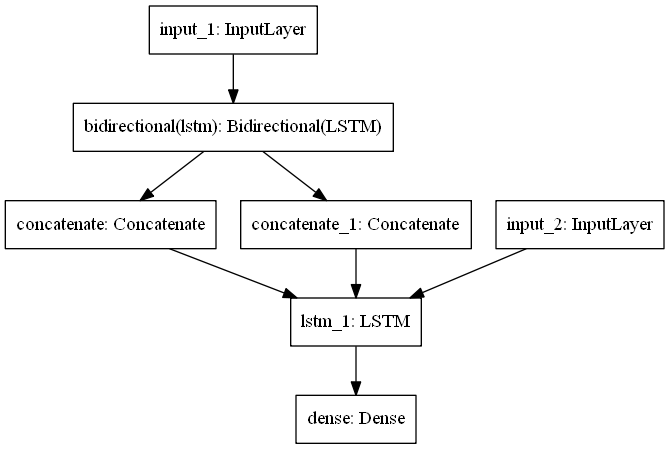

In [ ]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(train,to_file='model.png')
#tf.keras.utils.plot_model(train,to_file='/content/model.png')

dict_keys(['loss', 'acc', 'precision', 'recall', 'f1', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])


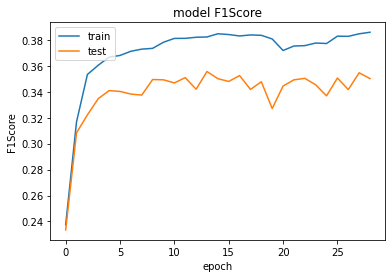

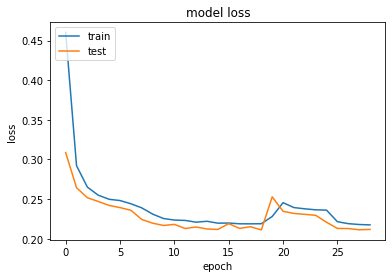

In [ ]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# generate target given source sequence
def predict_sequence(infenc, infdec, input, n_steps_out, n_features): 
  #n_steps_out->no. of time-step in output
  #n_features->no. of features in output
	# encode
	state = infenc.predict(input)
	# start of sequence input
	target_seq = array([0.0 for _ in range(n_features)]).reshape(1, 1, n_features)
	# collect predictions
	output = list()
	for t in range(n_steps_out):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

In [ ]:
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

### Evaluate with test sample

In [ ]:
prediction= []
n_features=4
n_steps_out = 267
for i in range(X1_test.shape[0]):
  test = X1_test[i]
  test = test[newaxis,:, :]
  pred = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
  pred = one_hot_decode(pred)
  prediction.extend(pred)

In [ ]:
#compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")

In [ ]:
truth = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          
    data.append(2)
  truth.extend(data)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

Confusion matrix : 
 [[1255  387    9]
 [1435  708   10]
 [   0    4 6872]]
              precision    recall  f1-score   support

           0       0.47      0.76      0.58      1651
           1       0.64      0.33      0.44      2153
           2       1.00      1.00      1.00      6876

    accuracy                           0.83     10680
   macro avg       0.70      0.70      0.67     10680
weighted avg       0.84      0.83      0.82     10680



### Examine single test sample

In [ ]:
test = X1_test[0]
test.shape
test = test[newaxis,:, :]
test.shape

(1, 534, 501)

In [ ]:
n_features=4
n_steps_out = 267
prediction = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [ ]:
truth = Y_test[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [ ]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

In [ ]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [ ]:
truth

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

### Examine training data (optional)

In [ ]:
test = X1[0]
test.shape
test = test[newaxis,:, :]
test.shape

In [ ]:
n_features=4
n_steps_out = 267
prediction = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [ ]:
truth = Y[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [ ]:
prediction

In [ ]:
truth